<a href="https://colab.research.google.com/github/vladimiralencar/DeepLearning-LANA/blob/master/tensorflow/TransferLearning_Tensorflow_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

https://arxiv.org/pdf/1411.1792.pdf

## Introdução

Vimos no item anterior como usar o modelo pré-treinado Inception para classificação de imagens. Infelizmente, o modelo Inception parecia incapaz de classificar imagens de pessoas. O motivo era o conjunto de dados usado para treinar o modelo Inception, que tinha alguns rótulos de texto confusos para as classes.

O modelo Inception é realmente bastante capaz de extrair informações úteis de uma imagem. Então poderíamos em vez disso treinar o modelo Inception usando outro conjunto de dados. Mas isso levaria várias semanas usando um computador muito poderoso e caro para treinar completamente o modelo Inception em um novo conjunto de dados.

Em vez disso, podemos reutilizar o modelo pré-treinado Inception e simplesmente substituir a camada que faz a classificação final. Isso é chamado de Transferência de Aprendizagem (Transfer Learning).

A transferência de aprendizagem envolve a utilização de uma rede neural pré-treinada e a adaptação da rede neural a um novo e diferente conjunto de dados. Mas isso depende de 2 pré-requisitos:

* O tamanho do novo conjunto de dados e
* A semelhança do novo conjunto de dados ao conjunto de dados original

## Flowchart

O diagrama a seguir mostra como o fluxo de dados é utilizado ao usar o modelo Inception para transferência de aprendizagem. Primeiro, nós inserimos e processamos uma imagem com o modelo Inception. Apenas antes da camada de classificação final do modelo inicial, salvamos os chamados valores de transferência para um arquivo de cache.

A razão para usar um arquivo de cache é que leva muito tempo para processar uma imagem com o modelo Inception. Se cada imagem for processada mais de uma vez, podemos economizar muito tempo ao armazenar em cache os valores de transferência.

Os valores de transferência também são chamados de valores de "estrangulamento" (bottleneck-values).

Quando todas as imagens no novo conjunto de dados forem processadas através do modelo Inception e os valores de transferência resultantes salvos em um arquivo de cache, podemos usar esses valores de transferência como entrada para outra rede neural. Em seguida, treinamos a segunda rede neural utilizando as classes a partir do novo conjunto de dados, de modo que a rede aprende como classificar imagens com base nos valores de transferência do modelo Inception. Desta forma, o modelo Inception é usado para extrair informações úteis das imagens e outra rede neural é usada para a classificação atual.

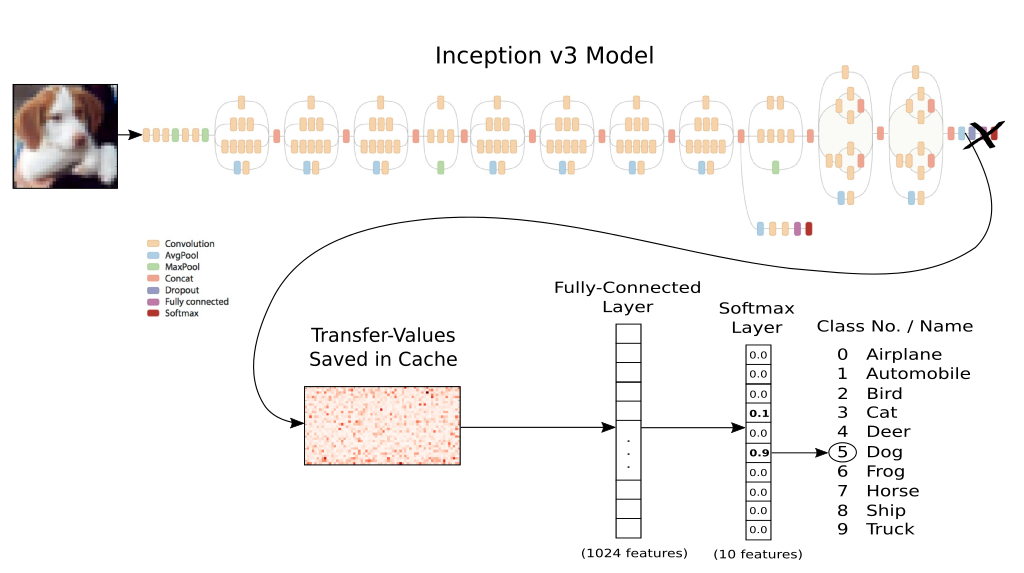

In [0]:
from IPython.display import Image, display
Image('images/transfer_learning_flowchart.png')

In [1]:
!nvidia-smi

Wed Mar 27 14:01:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [0]:
!wget https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/cifar10.py
!wget https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/cache.py
!wget https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/dataset.py
!wget https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/download.py
!wget https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/inception.py

In [0]:
!pip install tensorflow==1.0.1
!pip install prettytensor

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

# Funções e classes para carregar e usar o modelo Inception.
import inception

# Usamos Pretty Tensor para definir o novo classificador.
import prettytensor as pt

Desenvolvido usando a versão Python 3.6.1 (Anaconda) e TensorFlow:

In [0]:
tf.__version__

'1.0.1'

Versão do PrettyTensor:

In [0]:
pt.__version__

'0.7.4'

## Carregando o Dataset CIFAR-10 

In [0]:
import cifar10

As dimensões dos dados já foram definidas no módulo cifar10, então precisamos apenas importar as que precisamos.

In [0]:
from cifar10 import num_classes

O conjunto de dados CIFAR-10 possui cerca de 163 MB e será baixado automaticamente se ele não estiver localizado no caminho dado.

In [0]:
cifar10.maybe_download_and_extract()

Os dados aparentemente já foram baixados e descompactados.


In [0]:
class_names = cifar10.load_class_names()
class_names

Carregando os dados: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Carregando o conjunto de treinamento. Isso retorna as imagens, os números de classe como números inteiros e os números de classe como matrizes codificadas One-Hot chamadas de rótulos.

In [0]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Carregando os dados: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Carregando os dados: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Carregando os dados: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Carregando os dados: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Carregando os dados: data/CIFAR-10/cifar-10-batches-py/data_batch_5


Carrega o conjunto de teste.

In [0]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Carregando os dados: data/CIFAR-10/cifar-10-batches-py/test_batch


O conjunto de dados CIFAR-10 já foi carregado e consiste em 60.000 imagens e rótulos associadas (ou seja, classificações das imagens). O conjunto de dados é dividido em 2 subconjuntos mutuamente exclusivos, o conjunto de treinamento e o conjunto de teste.

In [0]:
print("Dataset de Treino:\t\t{}".format(len(images_train)))
print("Dataset de Teste:\t\t{}".format(len(images_test)))

Dataset de Treino:		50000
Dataset de Teste:		10000


### Função Auxiliar Para o Plot de Imagens

Função utilizada para plotar no máximo 9 imagens em uma grade 3x3 e escrever as classes verdadeiras e previstas abaixo de cada imagem.

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    fig, axes = plt.subplots(3, 3)

    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], interpolation=interpolation)

            cls_true_name = class_names[cls_true[i]]

            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

### Plot de algumas imagens

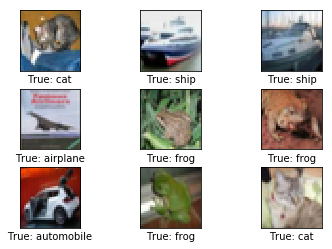

In [0]:
images = images_test[0:9]

cls_true = cls_test[0:9]

plot_images(images=images, cls_true=cls_true, smooth=False)

## Download do Modelo Inception 

O modelo Inception é baixado da internet. Este é o diretório padrão onde salvar os arquivos de dados. O diretório será criado se ele não existir.

In [0]:
# inception.data_dir = 'inception/'

In [0]:
inception.maybe_download()

Os dados aparentemente já foram baixados e descompactados.


## Carregando o Modelo Inception 

Carregue o modelo Inception para que esteja pronto para classificar imagens. 

In [0]:
model = inception.Inception()

## Calculando os Valores de Transferência

In [0]:
from inception import transfer_values_cache

Defina os caminhos dos arquivos para os caches do conjunto de treinamento e conjunto de testes.

In [0]:
file_path_cache_train = os.path.join(cifar10.data_path, 'inception_cifar10_train.pkl')
file_path_cache_test = os.path.join(cifar10.data_path, 'inception_cifar10_test.pkl')

In [0]:
print("\nProcessamento do Inception para transferência de valores para as imagens de treinamento.\n")
print("\nIsso vai demorar, pegue um café...\n")

# Escala de imagens porque o início precisa de pixels para estar entre 0 e 255,
# enquanto as funções CIFAR-10 retornam pixels entre 0,0 e 1,0
images_scaled = images_train * 255.0

# Se os valores de transferência já foram calculados, então recarregá-los,
# caso contrário, calcule-os e guarde-os em um arquivo de cache.
transfer_values_train = transfer_values_cache(cache_path = file_path_cache_train,
                                              images = images_scaled,
                                              model = model)


Processamento do Inception para transferência de valores para as imagens de treinamento.


Isso vai demorar, pegue um café...

- Dados carregados do arquivo de cache: data/CIFAR-10/inception_cifar10_train.pkl


In [0]:
print("\nProcessamento do Inception para transferência de valores para as imagens de teste.\n")
print("\nIsso vai demorar, pegue um café...\n")

# Escala de imagens porque o início precisa de pixels para estar entre 0 e 255,
# enquanto as funções CIFAR-10 retornam pixels entre 0,0 e 1,0
images_scaled = images_test * 255.0

# Se os valores de transferência já foram calculados, então recarregá-los,
# caso contrário, calcule-os e guarde-os em um arquivo de cache.
transfer_values_test = transfer_values_cache(cache_path = file_path_cache_test,
                                             images = images_scaled,
                                             model = model)


Processamento do Inception para transferência de valores para as imagens de teste.


Isso vai demorar, pegue um café...

- Processing image:  10000 / 10000
- Dados salvos no arquivo de cache: data/CIFAR-10/inception_cifar10_test.pkl


Verifique a forma da matriz com os valores de transferência. Há 50.000 imagens no conjunto de treinamento e para cada imagem há 2048 valores de transferência.

In [0]:
transfer_values_train.shape

(50000, 2048)

Da mesma forma, há 10.000 imagens no conjunto de teste com 2048 valores de transferência para cada imagem.

In [0]:
transfer_values_test.shape

(10000, 2048)

### Função Auxiliar Para Plotar os Valores de Transferência

In [0]:
def plot_transfer_values(i):
    print("Input image:")
    
    plt.imshow(images_test[i], interpolation='nearest')
    plt.show()

    print("Valores de Transferência para imagem usando Inception model:")
    
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


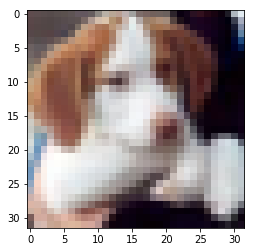

Valores de Transferência para imagem usando Inception model:


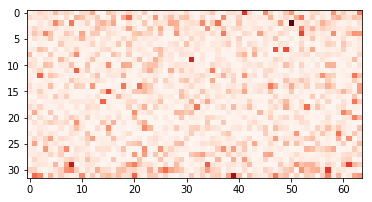

In [0]:
plot_transfer_values(i=16)

Input image:


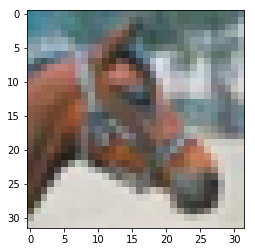

Valores de Transferência para imagem usando Inception model:


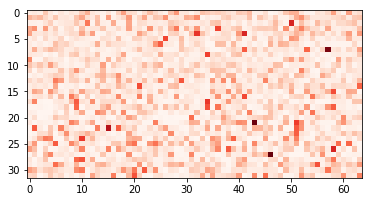

In [0]:
plot_transfer_values(i=17)

## Novo Classificador com TensorFlow

Agora vamos criar outra rede neural no TensorFlow. Esta rede receberá como entrada os valores de transferência do modelo Inception e exibirá as classes previstas para imagens CIFAR-10.

### Placeholders

Primeiro, precisamos do comprimento da matriz para os valores de transferência que é armazenado como uma variável no objeto para o modelo Inception.

In [0]:
transfer_len = model.transfer_len

Agora, criamos uma variável de espaço reservado para inserir os valores de transferência do modelo Inception na nova rede que estamos construindo. A forma desta variável é `[None, transfer_len]`, o que significa que ele recebe uma matriz de entrada com um número arbitrário de amostras como indicado pela palavra-chave `None` e cada amostra possui 2048 elementos, igual a` transfer_len`.

In [0]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

Criamos outra variável de espaço reservado para inserir o verdadeiro rótulo de classe de cada imagem. Estes são os chamadas arrays codificados One-Hot com 10 elementos, um para cada classe possível no conjunto de dados.

In [0]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

Calculamos a classe verdade como um número inteiro. Isso também pode ser uma variável de espaço reservado.

In [0]:
y_true_cls = tf.argmax(y_true, axis=1)

### Rede Neural

Cria a rede neural para fazer a classificação no conjunto de dados CIFAR-10. Isso recebe como entrada os valores de transferência do modelo Inception que serão alimentados na variável de espaço reservado `x`. A rede gera como resultado a classe prevista em `y_pred`.

In [0]:
# Wrap dos valores de transferência como um objeto Pretty Tensor.
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### Otimização

In [0]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

### Acurácia de Classificação

In [0]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [0]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [0]:
session = tf.Session()

### Inicializa as Variáveis

In [0]:
session.run(tf.global_variables_initializer())

### Função Auxiliar Para Obter Randomicamente o training-batch

Existem 50.000 imagens (e arrays com valores de transferência para as imagens) no conjunto de treinamento. Demora muito tempo calcular o gradiente do modelo usando todas essas imagens (valores de transferência). Portanto, usamos apenas um pequeno lote de imagens (valores de transferência) em cada iteração do otimizador.

Se o seu computador falhar ou se tornar muito lento porque você está sem memória RAM, então você pode tentar diminuir esse número, mas talvez seja necessário executar mais iterações de otimização.

In [0]:
train_batch_size = 64

In [0]:
def random_batch():
    num_images = len(transfer_values_train)

    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

### Função Auxiliar Para Otimização

In [0]:
def optimize(num_iterations):
    start_time = time.time()

    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()

        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)

        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)

            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    end_time = time.time()

    time_dif = end_time - start_time

    print("Tempo Gasto: " + str(timedelta(seconds=int(round(time_dif)))))

### Plot dos Erros

In [0]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)

    images = images_test[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = cls_test[incorrect]

    n = min(9, len(images))
    
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

### Plot da confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test, 
                          y_pred=cls_pred) 

    for i in range(num_classes):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Calculando a Classificação

In [0]:
# Divida o conjunto de dados em lotes deste tamanho para limitar o uso de RAM.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Número de imagens
    num_images = len(transfer_values)

    # Alocar uma matriz para as classes previstas que
    # serão calculadas em lotes e armazenadas nesta matriz.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Index
    i = 0

    while i < num_images:
        j = min(i + batch_size, num_images)

        feed_dict = {x: transfer_values[i:j], y_true: labels[i:j]}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j
        
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [0]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Calculando a Acurácia de Classificação

In [0]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

### Mostrando a Acurácia de Classificação

In [0]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Para todas as imagens no conjunto de teste,
    # calcular as classes previstas e se elas estão corretas.
    correct, cls_pred = predict_cls_test()
    
    # Precisão da classificação e o número de classificações corretas.
    acc, num_correct = classification_accuracy(correct)
    
    # Número de imagens sendo classificadas.
    num_images = len(correct)

    # Print da precisão.
    msg = "Acurácia no Dataset de Teste: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot de alguns exemplos de classificações erradas
    if show_example_errors:
        print("Errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot da confusion matrix
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Resultados

## Performance Antes da Otimização

In [0]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=False)

Acurácia no Dataset de Teste: 10.3% (1035 / 10000)


## Performance após 10.000 iterações de otimização

In [0]:
optimize(num_iterations=10000)

Global Step:    100, Training Batch Accuracy:  89.1%
Global Step:    200, Training Batch Accuracy:  84.4%
Global Step:    300, Training Batch Accuracy:  81.2%
Global Step:    400, Training Batch Accuracy:  89.1%
Global Step:    500, Training Batch Accuracy:  85.9%
Global Step:    600, Training Batch Accuracy:  84.4%
Global Step:    700, Training Batch Accuracy:  89.1%
Global Step:    800, Training Batch Accuracy:  89.1%
Global Step:    900, Training Batch Accuracy:  90.6%
Global Step:   1000, Training Batch Accuracy:  98.4%
Global Step:   1100, Training Batch Accuracy:  92.2%
Global Step:   1200, Training Batch Accuracy:  90.6%
Global Step:   1300, Training Batch Accuracy:  96.9%
Global Step:   1400, Training Batch Accuracy:  92.2%
Global Step:   1500, Training Batch Accuracy:  95.3%
Global Step:   1600, Training Batch Accuracy:  85.9%
Global Step:   1700, Training Batch Accuracy:  92.2%
Global Step:   1800, Training Batch Accuracy:  89.1%
Global Step:   1900, Training Batch Accuracy: 

Acurácia no Dataset de Teste: 90.4% (9039 / 10000)
Errors:


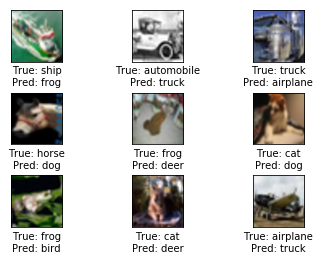

Confusion Matrix:
[914   6  17   0   7   1   1   2  37  15] (0) airplane
[  7 953   3   3   0   1   1   1   4  27] (1) automobile
[ 13   1 913  11  24  13  16   6   1   2] (2) bird
[  9   2  43 729  32 137  28  16   2   2] (3) cat
[  4   0  22  10 908  15  18  20   2   1] (4) deer
[  4   0   9  40  20 905   5  15   1   1] (5) dog
[  3   1  32   8  22  12 919   1   2   0] (6) frog
[  7   0  14   8  26  33   2 907   1   2] (7) horse
[ 29   6   1   2   1   2   1   0 951   7] (8) ship
[  7  34   2   0   2   1   1   1  12 940] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [0]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Encerra a Sessão TensorFlow

In [0]:
model.close()
session.close()

## Conclusão

Usamos o modelo Inception para obter uma precisão de classificação de cerca de 90% no conjunto de dados CIFAR-10. Isso foi feito alimentando todas as imagens do conjunto de dados CIFAR-10 através do modelo Inception e armazenando em cache os chamados valores de transferência antes da camada de classificação final. Em seguida, construímos outra rede neural que recebeu esses valores de transferência como entrada e produziu uma classe CIFAR-10 como saída.

O conjunto de dados CIFAR-10 contém um total de 60.000 imagens. O uso combinado de tempo desta técnica de Transfer Learning costuma ser menos da metade do tempo necessário para treinar uma rede neural diretamente para o conjunto de dados CIFAR-10 e alcançamos uma precisão de classificação significativamente maior.

Assim, transferir o aprendizado com o modelo Inception é útil para criar um classificador de imagem para o seu próprio conjunto de dados.